# Cat and Dog Classification

In [11]:
# try:
#   # This command only in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

# Get project files

In [4]:
##linux
# !wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
# !unzip cats_and_dogs.zip
##windows
import requests, zipfile
url = 'https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip'
filename = url.split('/')[-1]
r = requests.get(url, allow_redirects=True, stream=True)
with open(filename,'wb') as output_file:
    output_file.write(r.content)
print('Downloading Completed')
with zipfile.ZipFile("./cats_and_dogs.zip", 'r') as zip_ref:
    zip_ref.extractall("./")
print("Unziped")

Unziped


# Caminho dos Diretórios

In [2]:
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

## Get number of files in each directory. The train and validation directories

In [3]:
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.

In [4]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Processamento de Imagem

In [5]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255) 
test_image_generator = ImageDataGenerator(rescale=1./255) 

train_data_gen = train_image_generator.flow_from_directory(
        'cats_and_dogs/train',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size= batch_size,
        class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(
        'cats_and_dogs/validation',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size= batch_size,
        class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(
        'cats_and_dogs',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size= batch_size,
        class_mode='binary',
        shuffle=False,
		classes=['test'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


# Função que mostra as imagens no DB

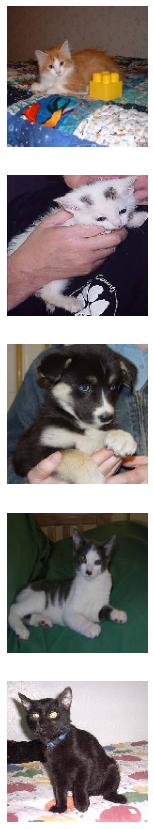

In [6]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

# Gerando váriações de dados

In [7]:
train_image_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255)

# Local para Salvar os dados sintéticos e Mostrar umas imagens sintética

Found 2000 images belonging to 2 classes.


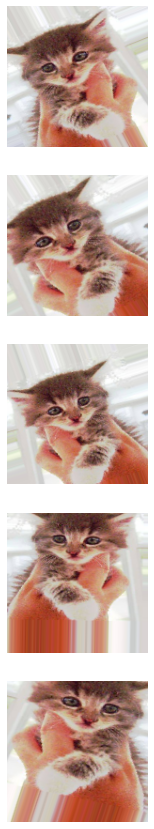

In [8]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
													directory=train_dir,
													target_size=(IMG_HEIGHT, IMG_WIDTH),
													class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Modelo de dados

In [12]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Mostrando estruturas e modelos

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 128)      


# Compilando e treinando o modelo

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

steps_per_epoch = 15
epochs = 10

history = model.fit(
    train_data_gen,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_data_gen,
    validation_steps=len(val_data_gen),
    epochs = epochs
)

Epoch 1/10


# Gráfico do treinamento

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Alinhando as predições

In [ ]:
probabilities = model.predict(test_data_gen).flatten()
probabilities

answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")